<a href="https://colab.research.google.com/github/Rogerio-mack/IA_2025S1/blob/main/AI_TF_ImageClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classificação de Imagens com Keras/TensorFlow**

Acesse: https://www.tensorflow.org/tutorials/images/classification?hl=pt-br

# Basic Imports

In [34]:
import tensorflow as tf
from tensorflow.keras import layers, models, Sequential
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import time

start_time = time.time()

# Load data using a Keras utility


In [22]:
# Baixar e extrair o dataset de flores
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

# Parâmetros de configuração
batch_size = 32
img_height = 180
img_width = 180

# Criar datasets de treino e validação
train_ds = tf.keras.utils.image_dataset_from_directory(
    '/root/.keras/datasets/flower_photos/flower_photos',
    validation_split=0.2,
    labels='inferred',  # Automatically infer labels from subdirectory names
    label_mode='categorical', # Use categorical labels (one-hot encoded)
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    '/root/.keras/datasets/flower_photos/flower_photos',
    validation_split=0.2,
    labels='inferred',  # Automatically infer labels from subdirectory names
    label_mode='categorical', # Use categorical labels (one-hot encoded)
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Verificar o formato dos dados para diagnóstico
for images, labels in train_ds.take(1):
    print("Imagens shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Exemplo de labels:", labels[:5].numpy())

# Obter os nomes das classes
class_names = train_ds.class_names
print("Nomes das classes:", class_names)
num_classes = len(class_names)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
Imagens shape: (32, 180, 180, 3)
Labels shape: (32, 5)
Exemplo de labels: [[0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]]
Nomes das classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


# Visualize the data



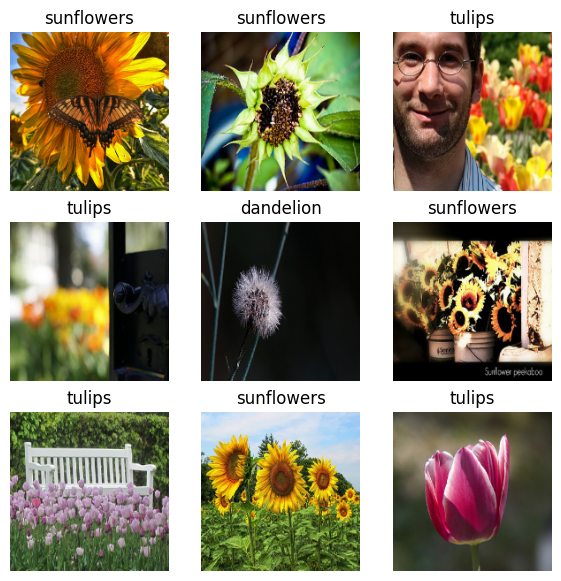

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i].numpy().argmax()])
    plt.axis("off")

In [24]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32, 5)


`(32, 180, 180, 3) = (batch_size=32, image_size=180x180, RGB=3)`


## Configure the dataset for performance

- `Dataset.cache`: mantêm as imagens em memória.
- `Dataset.prefetch`: sobrepõe o preprocessamento e o treinamento.

In [25]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

RGB tem valores de `[0, 255]` range que não são adequados para modelos de rede neural. Os dados podem ser normalizados para `[0, 1]`.

In [16]:
%%script echo off
normalization_layer = layers.Rescaling(1./255)

off


In [17]:
%%script echo off
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

off


Uma alternativa é incluir isso em uma camada do modelo. É a solução mais elegante e adotada aqui. As imagens também podem ter o tamanho alterado empregando `tf.keras.layers.Resizing`.

# A Basic Keras model

Empregamos aqui um modelo Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) com blocos de convolução e (`tf.keras.layers.Conv2D`) e pooling (`tf.keras.layers.MaxPooling2D`). Não e explorado nenhum ajuste do modelo aqui.

In [26]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

###Compile the model



* Se usar `SparseCategoricalCrossentropy`, certifique-se de que seus labels são índices (inteiros)
* Se usar `CategoricalCrossentropy`, certifique-se de que seus labels estão codificados one-hot. **É o que empregamos aqui**.

* Quando `from_logits=True`, a saída do modelo são logits brutos (antes do softmax) e os alvos sejam índices de classes (não codificados one-hot).
* Quando `from_logits=False`, a saída do modelo passa por uma ativação softmax e os alvos sejam índices de classes. **É o que empregamos aqui**.



In [28]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

### Model summary



In [29]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [30]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.3055 - loss: 1.8864 - val_accuracy: 0.5450 - val_loss: 1.1018
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.6038 - loss: 1.0167 - val_accuracy: 0.6185 - val_loss: 0.9859
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 88s 960ms/step - accuracy: 0.6988 - loss: 0.8113 - val_accuracy: 0.6567 - val_loss: 0.9152
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 90s 976ms/step - accuracy: 0.7601 - loss: 0.6502 - val_accuracy: 0.6431 - val_loss: 0.9759
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 141s 965ms/step - accuracy: 0.8551 - loss: 0.4074 - val_accuracy: 0.6117 - val_loss: 1.1046
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 91s 990ms/step - accuracy: 0.9347 - loss: 0.2256 - val_accuracy: 0.6267 - val_loss: 1.4284
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.9610 - loss: 0.1301 - val_accuracy: 0.6213 - val_loss: 1.6451
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 133s 947ms/step - accuracy: 0.9721 - loss: 0.1096 - val_accuracy: 

# History Train

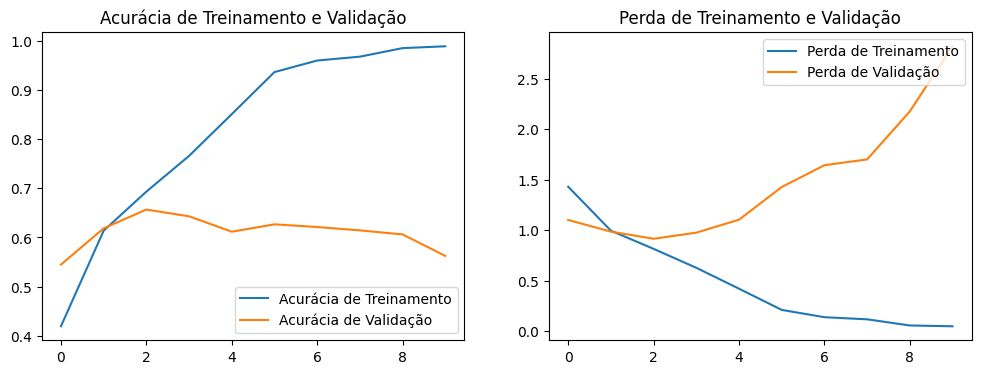

23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 302ms/step - accuracy: 0.5508 - loss: 2.9462
Acurácia no conjunto de validação: 0.5627


In [32]:
# Plotar a acurácia e perda durante o treinamento
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Acurácia de Treinamento')
plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
plt.legend(loc='lower right')
plt.title('Acurácia de Treinamento e Validação')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Perda de Treinamento')
plt.plot(epochs_range, val_loss, label='Perda de Validação')
plt.legend(loc='upper right')
plt.title('Perda de Treinamento e Validação')
plt.show()

# Avaliar o modelo
evaluation = model.evaluate(val_ds)
print(f"Acurácia no conjunto de validação: {evaluation[1]:.4f}")

# Make Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


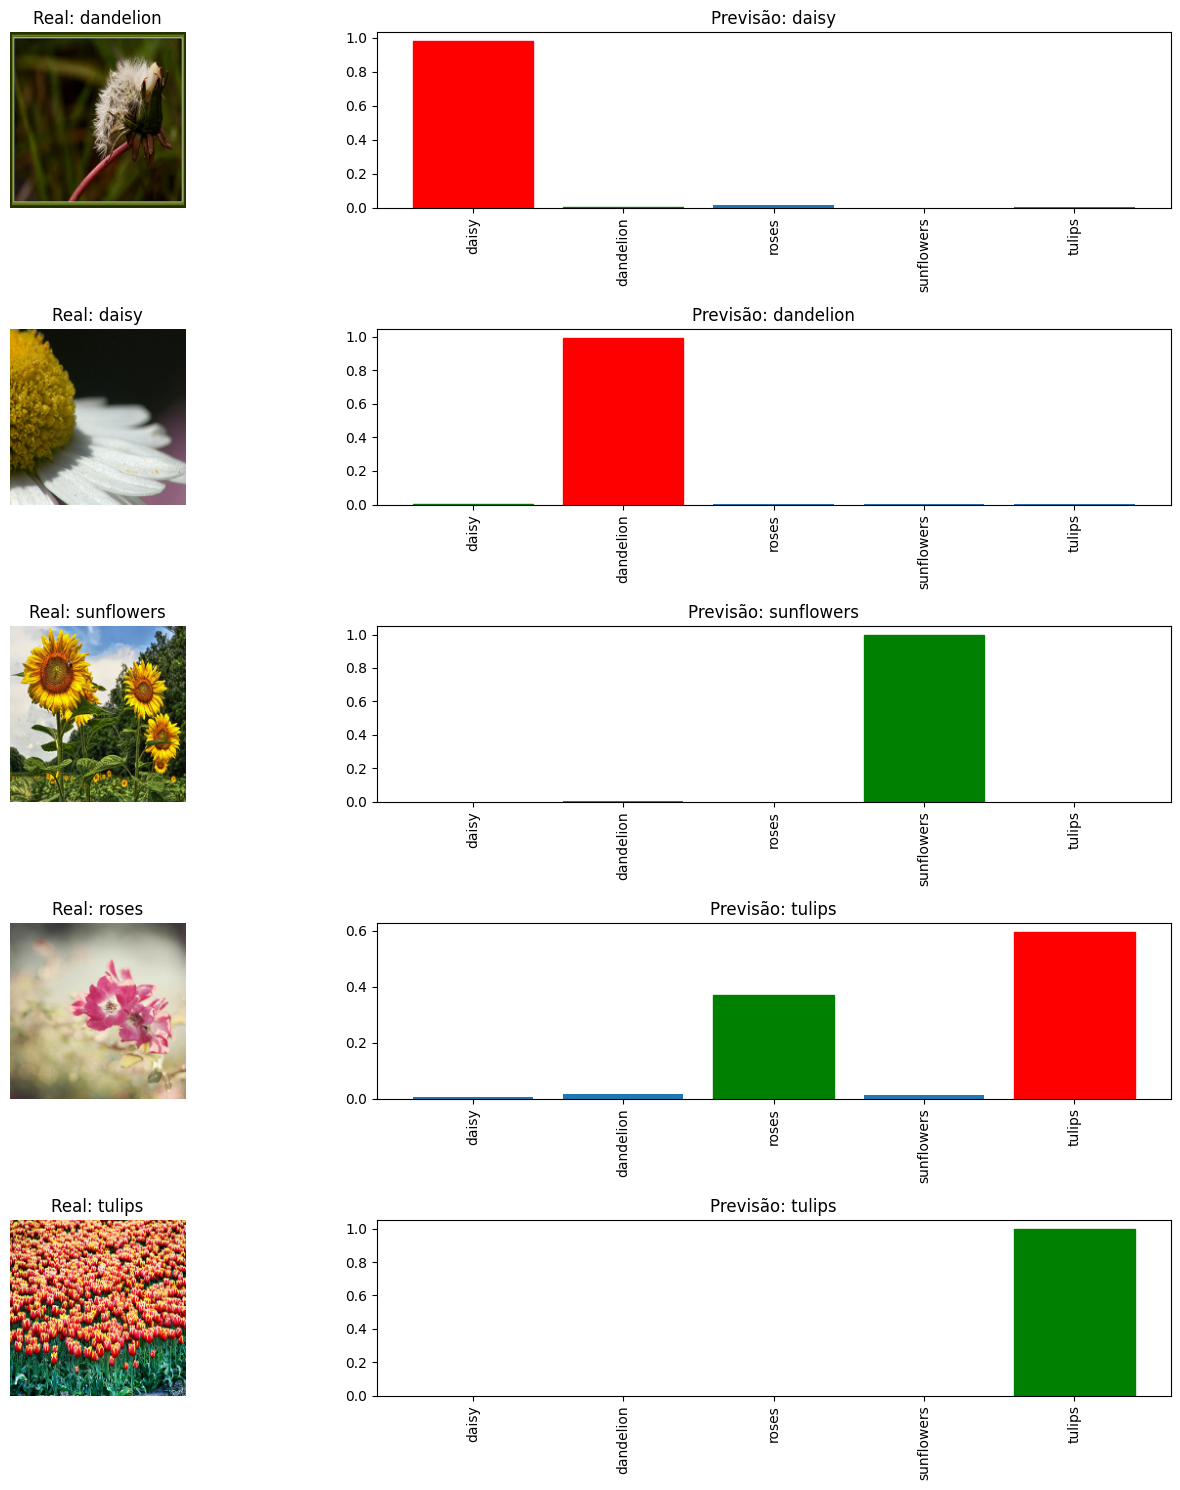

Modelo salvo como 'flower_classifier_categorical.h5'


In [35]:
# Função para fazer previsões e visualizá-las
def visualize_predictions(model, dataset, class_names, num_images=5):
    plt.figure(figsize=(15, 3*num_images))

    i = 0
    for images, labels in dataset.take(1):
        for j in range(min(num_images, len(images))):
            # Fazer a previsão
            img = tf.expand_dims(images[j], 0)
            predictions = model.predict(img)
            predicted_class = np.argmax(predictions[0])
            actual_class = np.argmax(labels[j])

            # Plotar a imagem
            plt.subplot(num_images, 2, i*2 + 1)
            plt.imshow(images[j].numpy().astype('uint8'))
            plt.title(f"Real: {class_names[actual_class]}")
            plt.axis('off')

            # Plotar as probabilidades
            plt.subplot(num_images, 2, i*2 + 2)
            barlist = plt.bar(range(len(class_names)), predictions[0])
            barlist[predicted_class].set_color('red')
            barlist[actual_class].set_color('green')
            plt.xticks(range(len(class_names)), class_names, rotation=90)
            plt.title(f"Previsão: {class_names[predicted_class]}")

            i += 1
            if i >= num_images:
                break

    plt.tight_layout()
    plt.show()

# Visualizar algumas previsões
visualize_predictions(model, val_ds, class_names)

# Salvar o modelo
model.save('flower_classifier_categorical.h5')
print("Modelo salvo como 'flower_classifier_categorical.h5'")

In [36]:
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time:.2f} seconds")

Training time: 2622.07 seconds
